In [346]:
#!/usr/bin/env python

# data tools
import os, cv2, glob, argparse
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# sklearn tools
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

# tf tools
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import backend as K
from tensorflow.keras.layers import (Conv2D,
                                     MaxPool2D,
                                     MaxPooling2D, 
                                     Activation, 
                                     Flatten,
                                     Dropout,
                                     Dense)
from tensorflow.keras.preprocessing.image import (load_img,
                                                  img_to_array,
                                                  ImageDataGenerator)
from tensorflow.keras.applications.vgg16 import (preprocess_input,
                                                 decode_predictions,
                                                 VGG16)

# Define model

In [347]:
base_model = tf.keras.applications.MobileNetV2(input_shape = (224, 224, 3), include_top = False, weights = "imagenet")
base_model.trainable = False
model = tf.keras.Sequential([base_model,
                                 tf.keras.layers.GlobalAveragePooling2D(),
                                 tf.keras.layers.Dropout(0.2),
                                 tf.keras.layers.Dense(2, activation="softmax")])

base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Define functions

In [374]:
height = 224
width = 224

def read_from_folders(folders):
    arrays = []
    labels = []
    
    for folder in folders:
        
        folderpath = os.path.join("data", folder)
        
        print(f"[INFO] Loading images from: \"{folderpath}\" ...") # Info for terminal
        
        for file in glob.glob(os.path.join(folderpath, "*.jpg")):
            arrays.append(cv2.imread(file))
            labels.append(f"{os.path.split(folderpath)[1]}")
    
    # Create dataframe from labels and arrays
    df = pd.DataFrame.from_dict({"X" : arrays, "y" : labels})
    
    return df

# Define function for resizing and making into array
def get_resized_arrays(arrays, width, height):
    # Info for terminal use
    print("[INFO] Resizing images ...")
    
    # If pd.series, convert to list
    if type(arrays) == "pandas.core.series.Series":
        arrays = list(arrays)
    
    # Empty list for appending to
    arrays_resized = []
    
    # For every array in the list of arrays
    for array in arrays:
        # Resize array
        resized = cv2.resize(array, (width, height), interpolation = cv2.INTER_AREA)
        
        # Convert to array and values between 0 and 1 to allow to be used in CNN (using list comprehension)
        resized = np.asarray(resized/255.).astype("float32")

        # Append to list
        arrays_resized.append(resized)

    # Return
    return arrays_resized

def get_formatted(X, y):
    # Format X
    X = np.array(X).reshape(len(X), width, height, 3)
    
    # Format y
    lb, enc = LabelEncoder(), OneHotEncoder()
    y = lb.fit_transform(y).reshape(-1,1)
    y = enc.fit_transform(y).toarray()
    
    return X, y

def plot_history(H, epochs):
    """
    Function which plots accuracy and loss over epochs
    """
    # Make a list of epochs
    epochs_range = range(epochs)
    
    # Create a plot showing accuracies
    plt.figure(figsize = (15, 15))
    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, H.history['accuracy'], label='Training accuracy')
    plt.plot(epochs_range, H.history['val_accuracy'], label='Validation accuracy')
    plt.legend(loc = 'lower right')
    plt.title('Training and Validation Accuracy')

    # Create a plot showing loss
    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, H.history['loss'], label='Training loss')
    plt.plot(epochs_range, H.history['val_loss'], label='Validation loss')
    plt.legend(loc = 'upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    plt.savefig(os.path.join("out", 'training_history.png'), format='png', dpi=100)

In [365]:
folders = os.listdir("data")
df = read_from_folders(folders)
df["X"] = get_resized_arrays(df["X"], 224, 224)

[INFO] Loading images from: "data/content_monet_style_cezanne" ...
[INFO] Loading images from: "data/content_monet_style_monet" ...
[INFO] Loading images from: "data/content_cezanne_style_monet" ...
[INFO] Loading images from: "data/content_cezanne_style_cezanne" ...
[INFO] Resizing images ...


# Train Monet/Cezanne classifier

In [375]:
# Create dataframe with subset
df_orig = df.loc[(df['y'] == "content_monet_style_monet") | (df['y'] == "content_cezanne_style_cezanne")]

In [376]:
# Define X and y
X = list(df_orig["X"])
y = list(df_orig["y"])

In [377]:
#Get labelnames
label_names = set(y)

In [378]:
# Format to match expected input for CNN
X, y = get_formatted(X, y)

In [372]:
# Make a test-train split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state = 9, # for replication purposes
                                                    train_size = .8)

In [373]:
history = model.fit(X_train, y_train, 
              validation_data=(X_test, y_test), 
              batch_size = 32,
              epochs = 5)

Epoch 1/5
25/25 [==============================] - 7s 292ms/step - loss: 0.1922 - accuracy: 0.9334 - val_loss: 0.1724 - val_accuracy: 0.9497
Epoch 2/5
25/25 [==============================] - 7s 284ms/step - loss: 0.1733 - accuracy: 0.9447 - val_loss: 0.1745 - val_accuracy: 0.9397
Epoch 3/5
25/25 [==============================] - 7s 289ms/step - loss: 0.1615 - accuracy: 0.9510 - val_loss: 0.1629 - val_accuracy: 0.9397
Epoch 4/5
25/25 [==============================] - 7s 280ms/step - loss: 0.1532 - accuracy: 0.9510 - val_loss: 0.1584 - val_accuracy: 0.9397
Epoch 5/5
25/25 [==============================] - 7s 276ms/step - loss: 0.1497 - accuracy: 0.9472 - val_loss: 0.1637 - val_accuracy: 0.9397


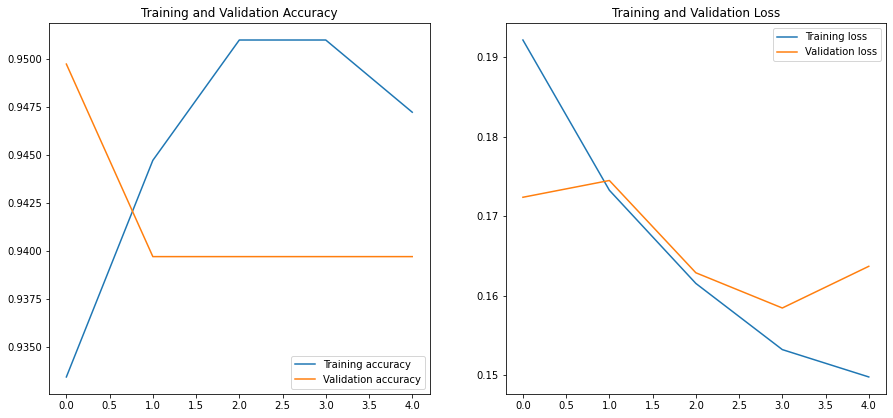

<Figure size 432x288 with 0 Axes>

In [389]:
plot_history(history, 5)

# Test Monet/Cezanne classifier

In [286]:
predictions = model.predict(X_test,
         batch_size = 32)

In [287]:
classif_report = pd.DataFrame(classification_report(y_test.argmax(axis=1),
                                predictions.argmax(axis=1),
                                target_names = label_names, output_dict = True))

In [288]:
classif_report

,content_monet_style_monet,content_cezanne_style_cezanne,accuracy,macro avg,weighted avg
precision,0.917431,0.988889,0.949749,0.953160,0.952621
recall,0.990099,0.908163,0.949749,0.949131,0.949749
f1-score,0.952381,0.946809,0.949749,0.949595,0.949637
support,101.000000,98.000000,0.949749,199.000000,199.000000


# Testing classifier on generated data

In [383]:
df_stylized = df.loc[(df['y'] == "content_monet_style_cezanne") | (df['y'] == "content_cezanne_style_monet")]
df_stylized = df_styliz.replace(['content_monet_style_cezanne'],'content_cezanne_style_cezanne')
df_stylized = df_styliz.replace(['content_cezanne_style_monet'],'content_monet_style_monet')

/usr/local/lib/python3.6/dist-packages/pandas/core/missing.py:49: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask = arr == x


In [384]:
X = list(df_stylized["X"])
y = list(df_stylized["y"])

In [385]:
# Format to match expected input for CNN
X_test, y_test = get_formatted(X, y)

In [386]:
predictions = model.predict(X_test,
         batch_size = 32)

In [387]:
classif_report = pd.DataFrame(classification_report(y_test.argmax(axis=1),
                                predictions.argmax(axis=1),
                                target_names = label_names, output_dict = True))

In [388]:
classif_report

,content_monet_style_monet,content_cezanne_style_cezanne,accuracy,macro avg,weighted avg
precision,0.754902,0.768595,0.761569,0.761749,0.761749
recall,0.774648,0.748491,0.761569,0.761569,0.761569
f1-score,0.764647,0.758410,0.761569,0.761529,0.761529
support,497.000000,497.000000,0.761569,994.000000,994.000000


In [ ]:
print(type(X_train), len(X_train), type(X_train[0]), X_train[0].shape)
print(type(y_train), len(y_train), type(y_train[0]), y_train[0])
